This is just a trash file where I tried to create my own RBM to get the best possible understanding and visualization of sampling and inference. It worked at some extent :)

In [1]:
using LinearAlgebra, Images, Plots, Distributions

In [2]:
using MLDatasets, Flux, Random

In [3]:
# Load MNIST dataset
X_train, Y_train = MLDatasets.MNIST(split=:train)[:];  # Training data
X_test, Y_test = MLDatasets.MNIST(split=:test)[:];     # Test data

# Normalize the input images (convert from 0-255 to 0-1 range)
X_train = Float32.(reshape(X_train, 28*28, :)) / 255.0;
X_train = Float32.(X_train);

In [4]:
mutable struct RBM
    W::Matrix{Float32}  # Weights between visible and hidden units
    b::Vector{Float32}  # Bias for visible units
    c::Vector{Float32}  # Bias for hidden units
end

# Initialize the RBM model
function init_rbm(n_visible::Int, n_hidden::Int)
    W = rand(Float32, n_visible, n_hidden) * 0.01  # Small random weights
    b = zeros(Float32, n_visible)  # Zero biases for visible units
    c = zeros(Float32, n_hidden)   # Zero biases for hidden units
    return RBM(W, b, c)
end
rbm1 = init_rbm(784, 128);
rbm2 = init_rbm(128,64);

In [5]:
# Sigmoid function
sigmoid(x) = 1.0 / (1.0 + exp(-x))

sigmoid (generic function with 1 method)

In [6]:
#sampling (i+1) layer from (i)th layer
function conditional_hidden_probs(rbm::RBM, v::Vector{Float32})
    # Compute activation for each hidden unit h_j
    # P(h_j = 1 | v) = σ(c_j + sum_i v_i W_ij)
    return sigmoid.(rbm.c .+ rbm.W' * v)
end
function sample_h_given_v(rbm::RBM, v::Vector{Float32})
    P_h_given_v = conditional_hidden_probs(rbm, v)
    # Sample h_j = 1 with probability P(h_j = 1 | v)
    return rand(Float32, length(P_h_given_v)) .< P_h_given_v
end

sample_h_given_v (generic function with 1 method)

In [27]:
#sampling (i)th layer from (i+1)
#Part1
function sample_from_gaussian(mean, variance)
    return rand(Normal(mean, sqrt(variance)))
end
# Discretize a value to the nearest multiple of 1/255
function discretize_pixel_value(v::Float32)
    # Scale to [0, 255], round to nearest integer, then rescale to [0, 1]
    return round(clamp(v, 0.0, 1.0) * 255) / 255.0
end

# Sample visible layer given the hidden layer, with discretization
function sample_visible_from_hidden(rbm::RBM, h::Vector{Float32}, variance::Float32=0.7)
    # Initialize the visible layer (continuous values)
    num_visible = size(rbm.W, 1)
    v = zeros(Float32, num_visible)
    
    # For each visible unit, sample from a Gaussian distribution
    for i in 1:num_visible
        mean = rbm.b[i] + dot(rbm.W[i, :], h)
        continuous_value = sample_from_gaussian(mean, variance)
        # Discretize to nearest pixel intensity level in {0, 1/255, ..., 255/255}
        v[i] = discretize_pixel_value(continuous_value)
    end
    v= Float32.(v)
    return v
end
#Part2
function conditional_visible_probs(rbm::RBM, h::Vector{Float32})
    # Compute activation for each visible unit v_i
    # P(v_i = 1 | h) = σ(b_i + sum_j h_j W_ij)
    P_v_given_h = sigmoid.(rbm.b .+ rbm.W * h)
    return rand(Float32,length(P_v_given_h)) .< P_v_given_h 
end


conditional_visible_probs (generic function with 1 method)

In [28]:
#gibbs sampling
#Part1
function gibbs_sampling_step1(rbm::RBM, v::Vector{Float32})
    # Positive phase: Compute P(h | v) and sample h
    h_sample = sample_h_given_v(rbm, v)
    h_sample = Float32.(h_sample)
    # Negative phase: Reconstruct v' from h, then sample h' from v'
    v_reconstructed = sample_visible_from_hidden(rbm, h_sample, Float32.(0.7))  # Sample v'
    v_reconstructed = Float32.(v_reconstructed)
    h_reconstructed = sample_h_given_v(rbm, v_reconstructed)  # Sample h' from v'
    h_reconstructed = Float32.(h_reconstructed)
    return v_reconstructed, h_reconstructed
end
#Part2
function gibbs_sampling_step2(rbm::RBM, v::Vector{Float32})
    # Positive phase: Compute P(h | v) and sample h
    h_sample = sample_h_given_v(rbm, v)
    h_sample = Float32.(h_sample)
    # Negative phase: Reconstruct v' from h, then sample h' from v'
    v_reconstructed = conditional_visible_probs(rbm, h_sample)
    v_reconstructed = Float32.(v_reconstructed)
    h_reconstructed = sample_h_given_v(rbm, v_reconstructed)  # Sample h' from v'
    h_reconstructed = Float32.(h_reconstructed)
    return v_reconstructed, h_reconstructed
end


gibbs_sampling_step2 (generic function with 1 method)

In [29]:
function update_weights!(rbm::RBM, v::Vector{Float32}, h::Vector{Float32}, v_reconstructed::Vector{Float32}, h_reconstructed::Vector{Float32}, eta::Float32)
    # Positive phase gradient
    dW_pos = v * h'
    
    # Negative phase gradient
    dW_neg = v_reconstructed * h_reconstructed'
    
    # Update the weights and biases
    rbm.W += eta * (dW_pos .- dW_neg)
    rbm.b += eta * (v .- v_reconstructed)
    rbm.c += eta * (h .- h_reconstructed)
end


update_weights! (generic function with 1 method)

In [30]:
function train_rbm!(rbm1::RBM, rbm2::RBM, X_train::Matrix{Float32}, epochs::Int, batch_size::Int, eta::Float32)
    n_samples = size(Float32.(X_train), 2)
    for epoch in 1:epochs
        println("Epoch $epoch")
        for i in 1:batch_size:n_samples
            batch = X_train[:, i:min(i + batch_size - 1, n_samples)]
            
            for v_sample in eachcol(batch)
                # Positive phase for RBM1
                h1_sample = sample_h_given_v(rbm1, Float32.(v_sample))
                
                # Gibbs sampling (negative phase) for RBM1
                v_reconstructed, h_reconstructed = gibbs_sampling_step1(rbm1, Float32.(v_sample))
                
                # Update weights for RBM1
                update_weights!(rbm1, Float32.(v_sample), Float32.(h1_sample), Float32.(v_reconstructed), Float32.(h_reconstructed), Float32.(eta))
                
                # Positive phase for RBM2
                h2_sample = sample_h_given_v(rbm2, Float32.(h1_sample))
                
                # Gibbs sampling (negative phase) for RBM2
                v_reconstructed2, h_reconstructed2 = gibbs_sampling_step2(rbm2, Float32.(h1_sample))
                
                # Update weights for RBM2
                update_weights!(rbm2, Float32.(h1_sample), Float32.(h2_sample), Float32.(v_reconstructed2), Float32.(h_reconstructed2), Float32.(eta))
            end
        end
    end
end

# Train the RBM with the MNIST data
train_rbm!(rbm1, rbm2, Float32.(X_train), 5, 100, Float32.(0.01))

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5


In [31]:

# Reconstruct an image using the two RBMs
function reconstruct_image(rbm1::RBM, rbm2::RBM, v::Vector{Float32})
    # Step 1: Forward pass through the first RBM to get hidden activations
    h1 = sample_h_given_v(rbm1, v)
    h1= Float32.(h1)
    # Step 2: Forward pass through the second RBM to get higher-level hidden activations
    h2 = sample_h_given_v(rbm2, h1)
    h2= Float32.(h2)
    # Step 3: Reconstruct the hidden representation of the second RBM
    h1_reconstructed = conditional_visible_probs(rbm2, h2)
    h1_reconstructed =Float32.(h1_reconstructed)
    # Step 4: Reconstruct the visible layer using the first RBM
    v_reconstructed = sample_visible_from_hidden(rbm1, h1_reconstructed, Float32.(0.8))
    
    return Float32.(v_reconstructed)
end

reconstruct_image (generic function with 1 method)

In [32]:
X_test = Float32.(reshape(X_test, 28*28, :))/255.0
v_test_sample = X_test[:,2]
v_test_sample = Float32.(v_test_sample)
v_reconstructed = reconstruct_image(rbm1, rbm2, v_test_sample)
original_image = reshape(v_test_sample, 28, 28)
reconstructed_image = reshape(v_reconstructed, 28, 28)

display(original_image)
display(reconstructed_image)

28×28 Matrix{Float32}:
 0.0  0.0  0.0  0.0  0.0          0.0          …  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0          0.0             0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0          0.0             0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0          0.0             0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0          0.0             0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0          0.0          …  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0          0.0             0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0          0.0             0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0          2.41049f-15     0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  2.41049f-15  3.6086f-15      0.0  0.0  0.0  0.0  0.0
 ⋮                                ⋮            ⋱            ⋮         
 0.0  0.0  0.0  0.0  0.0          0.0             0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0          0.0          …  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.

28×28 Matrix{Float32}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱                      ⋮         
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  

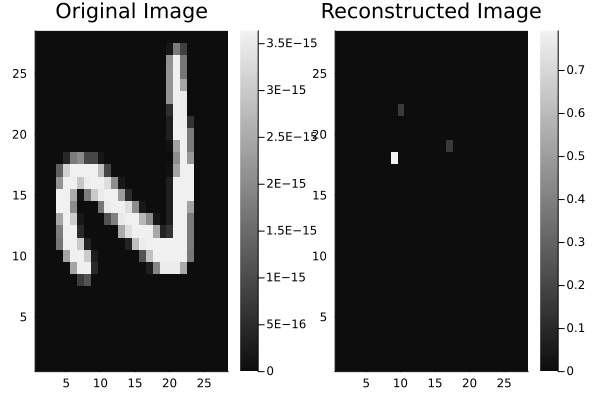

In [33]:
plot(heatmap(original_image, title="Original Image", color=:grays),
    heatmap(reconstructed_image, title="Reconstructed Image", color=:grays),
    layout=(1,2))

In [34]:
#I couldn't implement RBM on my own!!!